
---

### Dataset yang dipakai:
1. Dataset [Loan Approval Prediction] - Sumber [https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction]
---

### Codingan :

In [317]:
# === 1. IMPORT LIBRARY ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz-12.2.1-win64/bin/'
warnings.filterwarnings('ignore')
%matplotlib inline

In [318]:
# === 2. LOAD DATA ===
df = pd.read_csv("credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [319]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


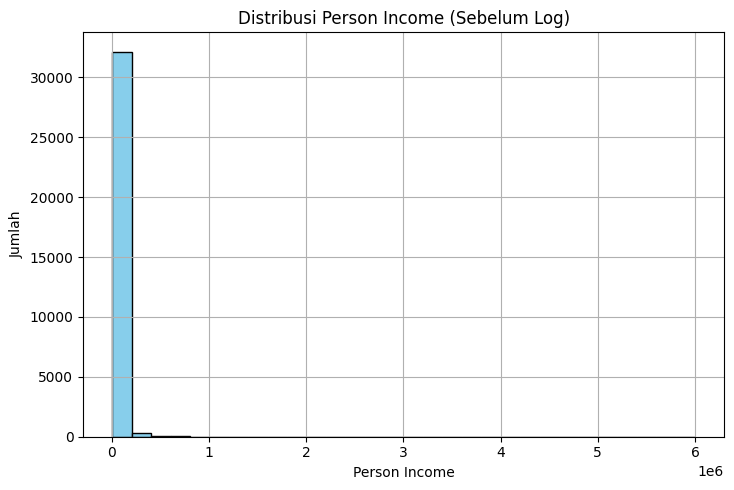

In [321]:
# Buat kolom log (jika belum ada)
if "person_income_log" not in df.columns:
    df["person_income_log"] = np.log1p(df["person_income"])  # log(1 + x) untuk hindari log(0)

# Visualisasi histogram: Sebelum dan Sesudah Log
plt.figure(figsize=(14, 5))

# Sebelum log
plt.subplot(1, 2, 1)
df["person_income"].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Distribusi Person Income (Sebelum Log)")
plt.xlabel("Person Income")
plt.ylabel("Jumlah")

plt.tight_layout()
plt.show()

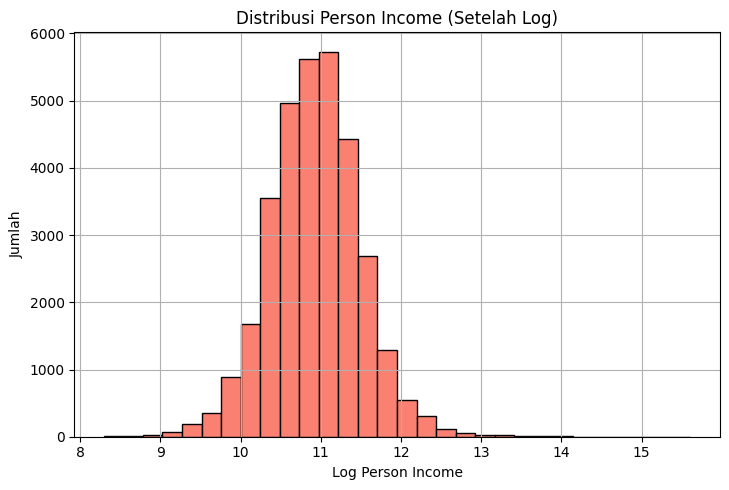

In [322]:
# Visualisasi histogram: Sebelum dan Sesudah Log
plt.figure(figsize=(14, 5))

# Sesudah log
plt.subplot(1, 2, 2)
df["person_income_log"].hist(bins=30, color='salmon', edgecolor='black')
plt.title("Distribusi Person Income (Setelah Log)")
plt.xlabel("Log Person Income")
plt.ylabel("Jumlah")

plt.tight_layout()
plt.show()

In [323]:
# === 3. DATA PREPROCESSING ===
# Drop missing target
df = df.dropna(subset=["loan_status"])

In [324]:
# Pisahkan fitur dan target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

In [325]:
# Label Encoding untuk fitur kategorikal
categorical_cols = X.select_dtypes(include="object").columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

In [326]:
# Imputasi nilai hilang dengan median
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

In [327]:
# Normalisasi fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [328]:
# FEATURE SELECTION DARI RANDOM FOREST
# Ambil nama fitur asli
original_feature_names = X.columns

# Hitung feature importance dari rf_model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Tampilkan Top-N fitur penting
top_n = 10
top_features = original_feature_names[indices[:top_n]]
print(f"=== Top {top_n} Feature Importances ===")
for i in range(top_n):
    print(f"{original_feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

=== Top 10 Feature Importances ===
loan_percent_income: 0.2224
loan_grade: 0.1859
loan_int_rate: 0.1238
person_income: 0.1120
person_income_log: 0.1084
person_home_ownership: 0.0887
loan_amnt: 0.0611
loan_intent: 0.0402
person_emp_length: 0.0225
cb_person_default_on_file: 0.0137


In [329]:
# Gunakan hanya top-N fitur untuk training dan testing
X_train_top = X_train[:, indices[:top_n]]
X_test_top = X_test[:, indices[:top_n]]

In [330]:
# === Train model dengan top features ===
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'),
                           param_grid,
                           cv=5,
                           scoring='roc_auc')

grid_search.fit(X_train_top, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='roc_auc')

In [331]:
# === 4. SPLIT DATA ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [332]:
# === 5. MODEL TRAINING (RANDOM FOREST) ===
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [333]:
# === 6. PREDIKSI ===
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

In [334]:
# === 5. MODEL TESTING & EVALUATION ===
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_top)
y_prob = best_model.predict_proba(X_test_top)[:, 1]

In [335]:
# === 7. EVALUASI MODEL ===
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_rf))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      5095
           1       0.82      0.74      0.78      1422

    accuracy                           0.91      6517
   macro avg       0.88      0.85      0.86      6517
weighted avg       0.91      0.91      0.91      6517



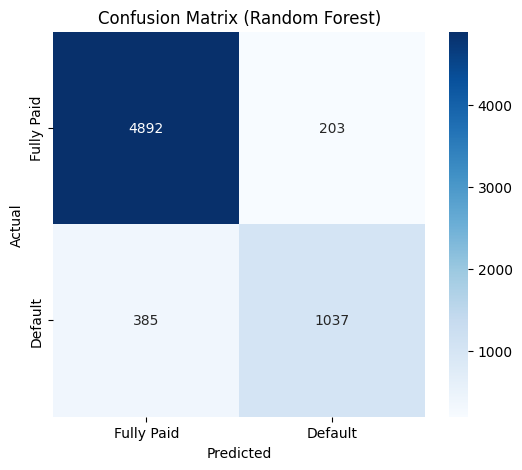

In [336]:
# === 8. VISUALISASI CONFUSION MATRIX ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fully Paid', 'Default'],
            yticklabels=['Fully Paid', 'Default'])
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

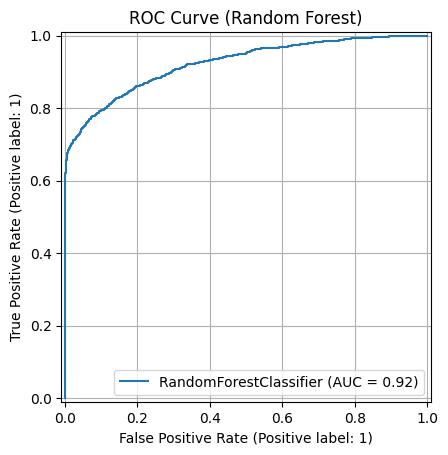

In [337]:
# === 9. VISUALISASI ROC CURVE ===
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("ROC Curve (Random Forest)")
plt.grid(True)
plt.show()

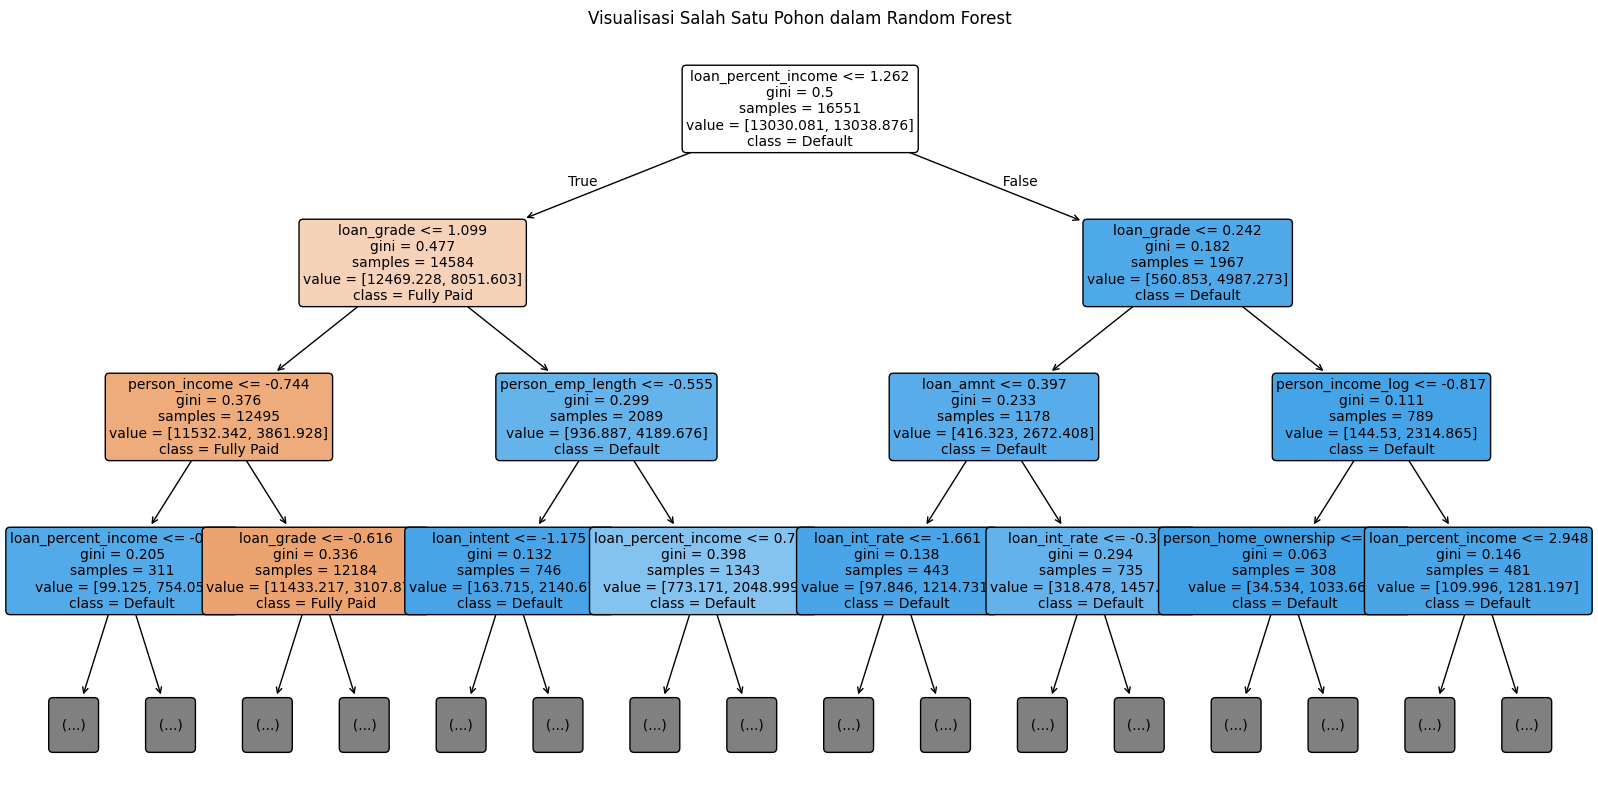

In [338]:
from sklearn.tree import plot_tree

# Ambil 10 fitur terpenting
top_features = original_feature_names[indices[:top_n]]

# Visualisasi salah satu pohon (misal estimator ke-0)
plt.figure(figsize=(20, 10))
plot_tree(
    rf_model.estimators_[0],
    feature_names=original_feature_names,
    class_names=["Fully Paid", "Default"],
    filled=True,
    rounded=True,
    max_depth=3,  # bisa ubah jadi None untuk pohon lengkap
    fontsize=10
)
plt.title("Visualisasi Salah Satu Pohon dalam Random Forest")
plt.show()

In [361]:
# === 10. CROSS-VALIDATION SCORE (5-fold) ===
cv_scores = cross_val_score(best_model, X_train_top, y_train, cv=5, scoring='roc_auc')
print(f"\n=== Cross-Validation ROC AUC Scores ===")
print(cv_scores)
print(f"Mean ROC AUC: {cv_scores.mean():.4f}")


=== Cross-Validation ROC AUC Scores ===
[0.86037862 0.85849143 0.84736856 0.84621044 0.86200895]
Mean ROC AUC: 0.8549
